Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import tensorflow as tf
import cv2
import gc
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import datasets, layers, models
from keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 0. How this notebook is structured

- In section 1 we read the data, shuffle it, standardize it, and expand the validation set. You must run this in its entirety
- In section 2 we train the model - Just skip this and go to section 3 and load the model if you don't want to train something ne
- In section 4 we test the model and output some performance indicators

Each section has additional info

## 1. Read Data and Format

You must Specify the datatype that you will use
- comressed is processed + autoencoded
- processed data is much slower than compressed
- you should have these data at hand in the relevant folder , use the autoencoder.ipynb if you dont have them

In [2]:
from pathlib import Path
current_path = Path('.').resolve()
base_dir = current_path.parent.parent / "pca_data"
print(base_dir)

C:\Users\feyzi\Downloads\Git7641\Project-CS7641\pca_data


In [3]:
x_train_file = "images_pca_train.csv"
y_train_file = "labels_train.csv"
x_validation_file = "images_pca_val.csv"
y_validation_file = "labels_val.csv"
x_test_file = "images_pca_test.csv"
y_test_file = "labels_test.csv"

In [4]:
X_train = pd.read_csv(base_dir / x_train_file, header=None)
y_train = pd.read_csv(base_dir / y_train_file, header=None)
X_val = pd.read_csv(base_dir / x_validation_file, header=None)
y_val = pd.read_csv(base_dir / y_validation_file, header=None)
X_test = pd.read_csv(base_dir / x_test_file, header=None)
y_test = pd.read_csv(base_dir / y_test_file, header=None)

First lets combine train and val

In [5]:
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.716034,-12.223699,-3.473387,-0.589188,-1.226007,-1.534919,3.120214,-3.006178,3.677769,1.293204,...,0.547199,-0.769362,0.359772,-1.524973,-1.381995,0.982144,-0.007283,0.816764,1.630617,1.604625
1,-5.878401,-8.760146,-7.008696,4.328204,3.736198,1.830571,-3.759173,0.472455,3.697279,6.219872,...,-0.170695,-1.290282,0.732231,0.630204,0.630468,-0.898629,-0.235443,-0.330536,-0.243427,-1.052879
2,18.794453,21.034306,7.120292,-0.773911,0.037064,-6.386395,-2.026241,0.308292,-1.842266,2.699912,...,-0.887213,-0.092992,-1.023429,-2.393702,1.327690,2.522655,2.556782,-0.891150,0.553456,2.688059
3,-20.382483,5.769042,4.590059,3.796414,0.578571,2.210527,2.578104,-1.618204,-1.037445,-1.076730,...,-0.572765,0.068932,-0.540302,-0.141777,0.087831,0.280229,-0.487348,0.744984,1.390412,0.376715
4,0.132107,23.233835,-6.365599,-13.595055,8.608768,1.499474,-2.723221,-0.796950,-2.157047,-0.656189,...,0.733675,-0.466582,1.135399,0.322292,-0.821335,-0.093764,-0.422851,0.870946,0.379858,-0.172859


Get the first 10 PCAs

In [6]:
X_train = X_train[[1,2,3,4,5,6,7,8,9]]
X_test = X_test[[1,2,3,4,5,6,7,8,9]]

Convert to numpy arrays

In [7]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

Check for nans

In [8]:
print(np.isnan(X_train).any())
print(np.isnan(X_test).any())

False
False


In [9]:
np.amax(X_train)

42.00017166137695

In [10]:
np.max(X_test)

32.0127067565918

Use SKlearn standard scaler

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

One Hot Encode output labels

In [13]:
print(y_train.shape)

(6364, 1)


In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
X_train.shape

(6364, 9)

The validation data is very small so I will make it 10% of training data

In [16]:
ten_percent = int(0.1 * len(X_train))
random_indices = np.random.choice(len(X_train), ten_percent, replace=False)

X_val = X_train[random_indices]
y_val = y_train[random_indices]

X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)



In [17]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(5728, 9) (5728, 4) (636, 9) (636, 4)


Check for data imbalance

In [18]:
y_train_check = np.argmax(y_train, axis=1)

y_test_check = np.argmax(y_test, axis=1)

In [19]:
unique, counts = np.unique(y_train_check, return_counts=True)
counts = np.round(counts / len(y_train_check) * 100, 2)
print("Train", dict(zip(unique, counts)))

unique, counts = np.unique(y_test_check, return_counts=True)
counts = np.round(counts / len(y_test_check) * 100, 2)
print("Test", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
counts = np.round(counts / len(y_val) * 100, 2)
print("Validation", dict(zip(unique, counts)))

Train {0: 7.37, 1: 21.28, 2: 60.91, 3: 10.44}
Test {0: 13.75, 1: 30.35, 2: 50.58, 3: 5.32}
Validation {0.0: 300.0, 1.0: 100.0}


### Imbalanced class weight Fix : Upsampling?

## 2. Define Model and Train (Or skip this and go to 3. Load Model) 

In [20]:
num_classes = 4
n1, n2 = X_train.shape
print(n1, n2)

5728 9


In [30]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(n2,)),  # Input layer (10 PCs)
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),                     # Hidden layer
    Dense(num_classes, activation='softmax')          # Output layer
])

In [31]:
model.compile(optimizer='adam',
              loss ='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.get_logger().setLevel('INFO')
tf.debugging.set_log_device_placement(True)

In [33]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, 
                    shuffle=True,
                    batch_size = 8, validation_data=(X_val, y_val), verbose = 1) 

Epoch 1/20
716/716 [==============================] - 5s 7ms/step - loss: 0.9419 - accuracy: 0.6152 - val_loss: 0.5665 - val_accuracy: 0.8019
Epoch 2/20
716/716 [==============================] - 5s 7ms/step - loss: 0.6162 - accuracy: 0.7767 - val_loss: 0.4391 - val_accuracy: 0.8443
Epoch 3/20
716/716 [==============================] - 4s 6ms/step - loss: 0.5562 - accuracy: 0.8027 - val_loss: 0.4126 - val_accuracy: 0.8632
Epoch 4/20
716/716 [==============================] - 5s 6ms/step - loss: 0.5295 - accuracy: 0.8055 - val_loss: 0.3959 - val_accuracy: 0.8648
Epoch 5/20
716/716 [==============================] - 5s 7ms/step - loss: 0.4986 - accuracy: 0.8167 - val_loss: 0.3876 - val_accuracy: 0.8664
Epoch 6/20
716/716 [==============================] - 4s 6ms/step - loss: 0.5017 - accuracy: 0.8141 - val_loss: 0.3723 - val_accuracy: 0.8695
Epoch 7/20
716/716 [==============================] - 5s 7ms/step - loss: 0.4837 - accuracy: 0.8233 - val_loss: 0.3740 - val_accuracy: 0.8648
Epoch 

Plot validation and train data accuracy history

In [34]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


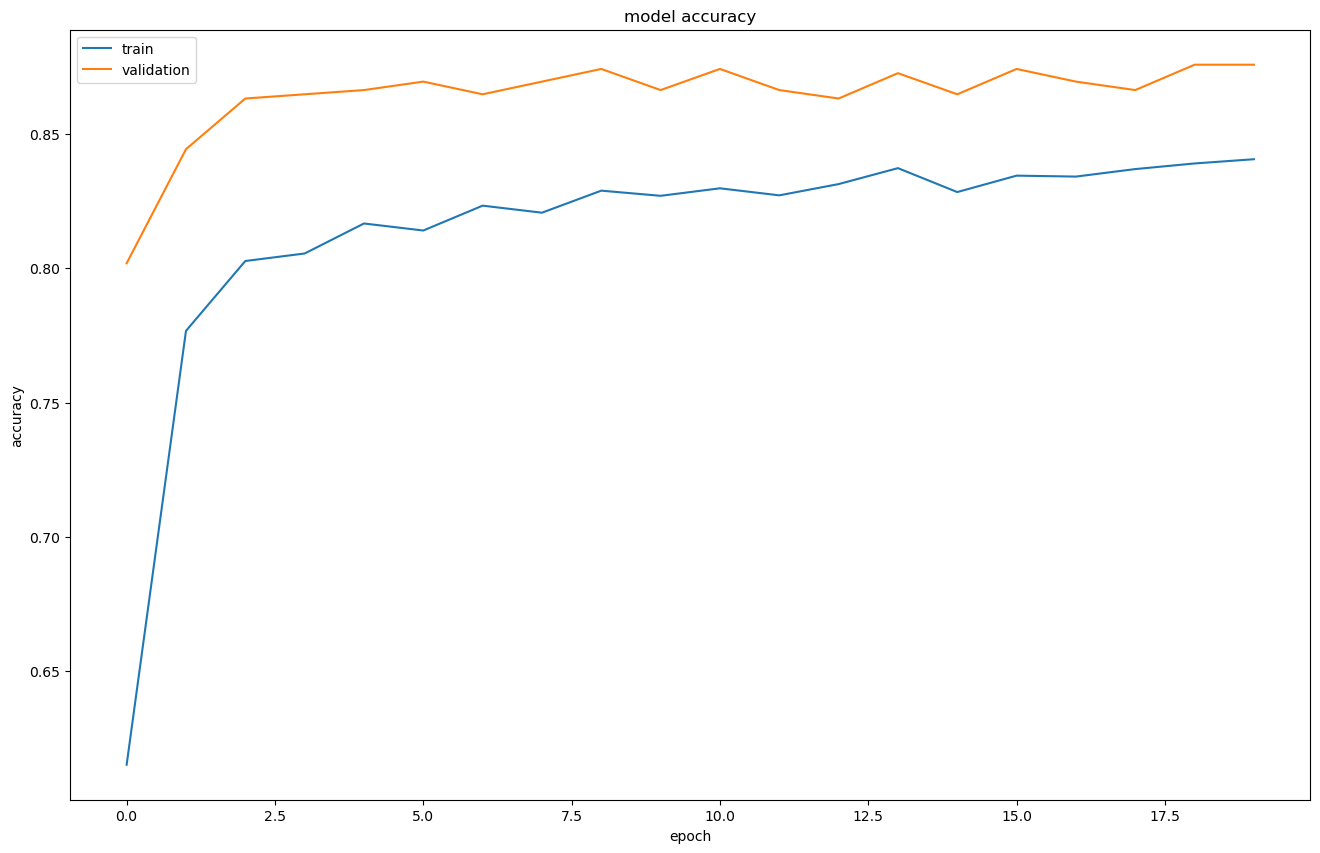

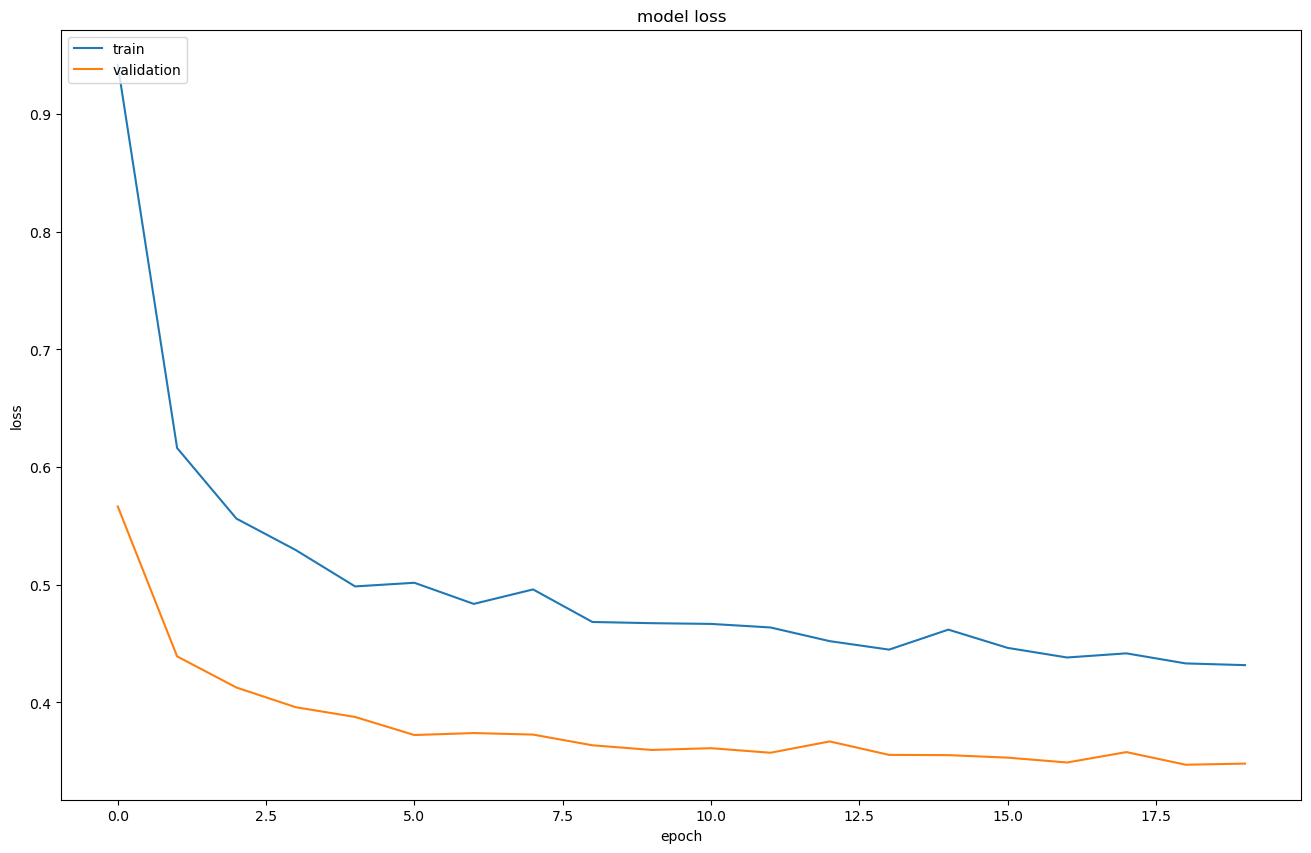

In [35]:
# summarize history for accuracy
plt.figure(figsize=(16,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.figure(figsize=(16,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### 2.9 Save model

- If you train a new model and save it, name it something else so it doesnt overwrite an existing one

In [27]:
# model.save('trained_models/NN_V1_PCAImages')

INFO:tensorflow:Assets written to: trained_models/NN_V1_PCAImages\assets


## 3. Load model

Pick version to use, there should be two models for each version, one for compressed and one for processed images

In [28]:
# # Specify the version you want to load
# model_to_load =  "trained_models/NN_V1_PCAImages"

# model = keras.models.load_model(model_to_load)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,852
Trainable params: 2,852
Non-trainable params: 0
_________________________________________________________________


## 4. Display Results

Make predictions and correct dimensions

In [36]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# fix formatting - currently one-hot encoded
y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_val = np.argmax(y_pred_val, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

# fix formatting
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


25/25 [==============================] - 0s 3ms/step


Generate confusion matrices

In [37]:

cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)


Plot confusion matrices

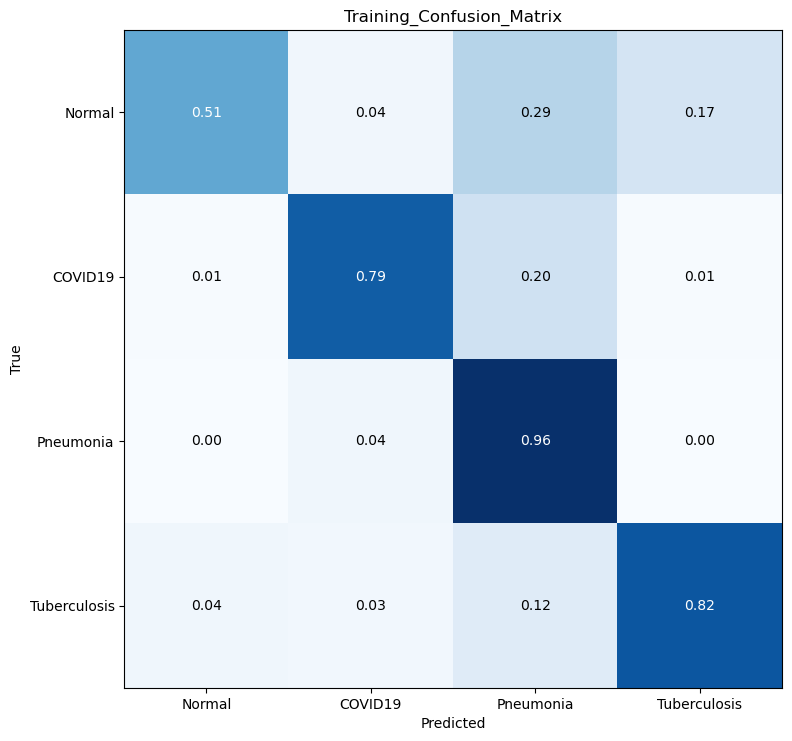

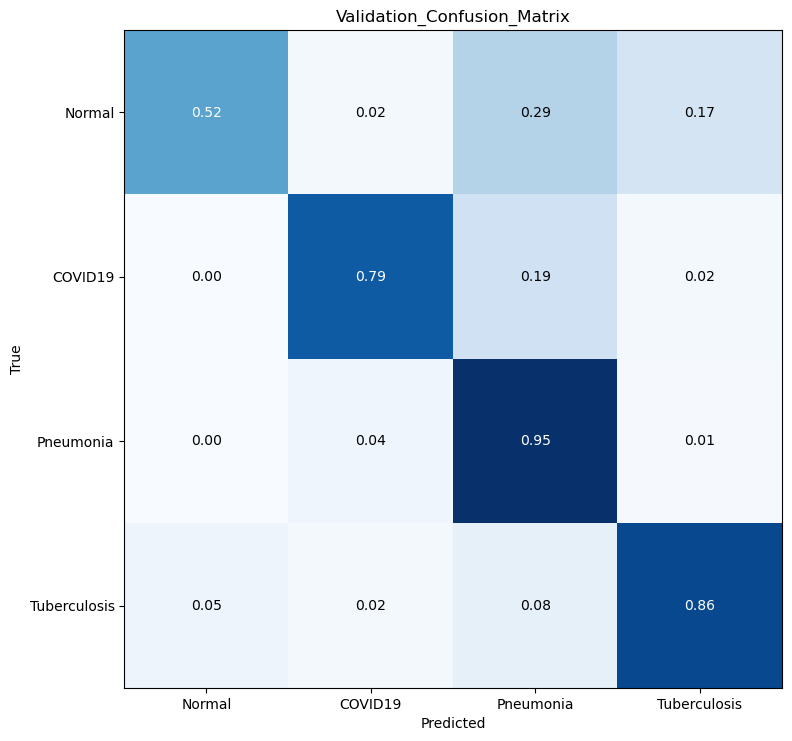

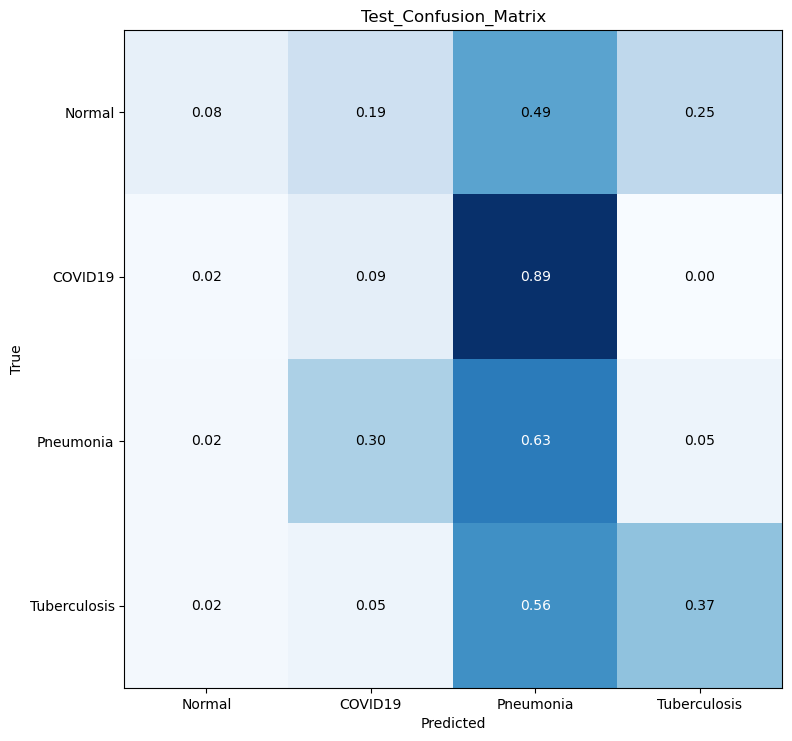

In [38]:
def plot_cm(cm, title):
    cm_sum = np.sum(cm, axis=1, keepdims=True) # cumulative sum
    cm_ratio = cm / cm_sum.astype(float) # so we display percetnages


    # plt.figure(figsize=(8, 8), dpi=400)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm_ratio, cmap='Blues')
    plt.title(title)
    # plt.colorbar()

    classes = [0, 1, 2, 3]
    labels = ['Normal', 'COVID19', 'Pneumonia', 'Tuberculosis']
    class_labels = dict(zip(classes, labels))
    plt.xticks(ticks=classes, labels=class_labels.values())
    plt.yticks(ticks=classes, labels=class_labels.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    
    # Loop through and add numbers to each box
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm_ratio[i, j]:.2f}", 
                     ha="center", va="center", 
                     color="black" if cm_ratio[i, j] < 0.5 else "white")
            
    plt.tight_layout()
    # plt.savefig(f"../assets/images/{title}_NNPCA.jpg", dpi=400)
    plt.show()

plot_cm(cm_train, 'Training_Confusion_Matrix')
plot_cm(cm_val, 'Validation_Confusion_Matrix')
plot_cm(cm_test, 'Test_Confusion_Matrix')

Check what class 0 is being misclassfied as

Summary stats

In [33]:
# using sklearn.metrics classification report function
print("Train Data Stats:")
print(classification_report(y_true_train, y_pred_train))

print("\nValidation Data Stats:")
print(classification_report(y_true_val, y_pred_val))

print("\nTest Data Stats:")
print(classification_report(y_true_test, y_pred_test))

Train Data Stats:
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       416
           1       0.82      0.84      0.83      1221
           2       0.91      0.94      0.93      3498
           3       0.88      0.78      0.83       593

    accuracy                           0.88      5728
   macro avg       0.86      0.81      0.83      5728
weighted avg       0.88      0.88      0.88      5728


Validation Data Stats:
              precision    recall  f1-score   support

           0       0.74      0.59      0.66        54
           1       0.82      0.85      0.84       128
           2       0.91      0.94      0.92       385
           3       0.84      0.78      0.81        69

    accuracy                           0.87       636
   macro avg       0.83      0.79      0.81       636
weighted avg       0.87      0.87      0.87       636


Test Data Stats:
              precision    recall  f1-score   support

           0   

## Model performances - Notes for previous models

### V2 Compressed

Train Data Stats:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1201
           1       1.00      1.00      1.00       417
           2       1.00      1.00      1.00      3491
           3       1.00      1.00      1.00       585

    accuracy                           1.00      5694
   macro avg       1.00      1.00      1.00      5694
weighted avg       1.00      1.00      1.00      5694


Validation Data Stats:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       148
           1       0.84      0.87      0.85        53
           2       0.98      0.96      0.97       392
           3       0.91      0.95      0.93        77

    accuracy                           0.95       670
   macro avg       0.92      0.93      0.92       670
weighted avg       0.95      0.95      0.95       670


Test Data Stats:
              precision    recall  f1-score   support

           0       0.93      0.44      0.59       234
           1       0.87      0.89      0.88       106
           2       0.76      0.98      0.86       390
           3       0.85      0.95      0.90        41

    accuracy                           0.80       771
   macro avg       0.85      0.81      0.81       771
weighted avg       0.83      0.80      0.78       771


V2 Processed

Train Data Stats:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1194
           1       1.00      1.00      1.00       429
           2       1.00      1.00      1.00      3480
           3       1.00      1.00      1.00       591

    accuracy                           1.00      5694
   macro avg       1.00      1.00      1.00      5694
weighted avg       1.00      1.00      1.00      5694


Validation Data Stats:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       155
           1       0.84      1.00      0.91        41
           2       0.98      0.97      0.98       403
           3       1.00      0.96      0.98        71

    accuracy                           0.97       670
   macro avg       0.94      0.97      0.95       670
weighted avg       0.97      0.97      0.97       670


Test Data Stats:
              precision    recall  f1-score   support

           0       0.96      0.39      0.56       234
           1       0.88      0.93      0.91       106
           2       0.74      0.99      0.85       390
           3       0.98      0.98      0.98        41

    accuracy                           0.80       771
   macro avg       0.89      0.82      0.82       771
weighted avg       0.84      0.80      0.78       771
